In [1]:
import os
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
#from torchvision.datasets import MNIST
#import torchvision.transforms as transforms
from torch.utils.data import Dataset
import spacy
#import pytorch_lightning as pl
#from pytorch_lightning import Trainer
import matplotlib.pyplot as plt
import numpy as np
from scipy import linalg
import scipy
from sklearn.manifold import TSNE
import sklearn
from sklearn.linear_model import LinearRegression, Ridge, SGDClassifier
from sklearn.svm import LinearSVC, SVR
from sklearn.multioutput import MultiOutputRegressor
#from sklearn.datasets import fetch_mldata
from sklearn.decomposition import PCA
import scipy.io
import random
import inlp
from sklearn.manifold import TSNE
import matplotlib
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import torch
from transformers import BertTokenizer, BertModel, BertForMaskedLM, BertConfig, RobertaModel, RobertaForMaskedLM, RobertaTokenizer, RobertaConfig
from transformers import AutoTokenizer, AutoModel, AutoConfig
from transformers import AlbertTokenizer, AlbertModel, AlbertConfig
from transformers import XLNetTokenizer, XLNetModel, XLNetConfig

from typing import Tuple, Dict
from typing import List
import tqdm
from tqdm import tqdm_notebook
import urllib
import time
import pickle
import inlp, inlp_dataset_handler, inlp_linear_model
import copy
%load_ext autoreload
%autoreload

INFO:transformers.file_utils:PyTorch version 1.4.0 available.


In [4]:
def load_wiki(url = "http://nlp.biu.ac.il/~ravfogs/resources/wiki.1million.raw.txt"):
    
  response = urllib.request.urlopen(url)
  raw = response.read().decode('utf8')
  sents = raw.split("\n")
  
  return sents[:]


def create_docs(sentences: List[str]) -> List[spacy.tokens.Doc]:

    #parsing and toekenizing (NOTE: takes about 10 minutes)
    
    nlp = spacy.load('en_core_web_sm')
    nlp.remove_pipe("ner")
    
    start = time.time()
    
    docs = list(nlp.pipe(sentences, batch_size = 100))
    
    docs = list(docs)
    print(time.time() - start)
    
    return docs


def collect_rec_dataset(docs, n):
    
    contain_rec = []
    for i, doc in tqdm.notebook.tqdm(enumerate(docs), total = len(docs)):
        deps = [tok.dep_ for tok in doc]
        if "relcl" in deps:
            contain_rec.append(doc)
    
    contain_rec_set = set(contain_rec)
    no_rec = [d for d in docs if d not in contain_rec_set]
    data = []
    for i in range(n):
        
        doc_with_rec = random.choice(contain_rec)
        rec_root = random.choice([tok for tok in doc_with_rec if tok.dep_ == "relcl"])
        rec_subtree = list(rec_root.subtree)
        rec_borders = (rec_subtree[0].i, rec_subtree[-1].i)
        rec_subtree_text = [tok.text for tok in rec_subtree]
        is_reduced_relc = "that" not in rec_subtree_text and "which" not in rec_subtree_text and "who" not in rec_subtree_text and "whom" not in rec_subtree_text and "whose" not in rec_subtree_text and "where" not in rec_subtree_text 
        
        # add positive & negative examples
        
        data.append({"doc": doc_with_rec, "relc_borders": rec_borders, "is_reduced": is_reduced_relc, "relc_root_ind": rec_root.i, "label": 1})
        data.append({"doc": random.choice(no_rec), "relc_borders": None, "is_reduced": None, "relc_root_ind": None, "label": 0})
    
    random.shuffle(data)
    return data
    

In [3]:
wiki_sents = load_wiki()

KeyboardInterrupt: 

In [ ]:
wiki_sents = wiki_sents[:200000]
print(wiki_sents[0])
docs = create_docs(wiki_sents)

In [ ]:
with open("sents.pickle", "wb") as f:
    pickle.dump(wiki_sents, f)
    
with open("docs.pickle", "wb") as f:
    pickle.dump(docs, f)

In [7]:
with open("docs.pickle", "rb") as f:
    docs = pickle.load(f)

In [8]:
docs = [d for d in docs if len(d) > 11 and len(d) < 35]
data = collect_rec_dataset(docs, n = 75000)

In [9]:
relc_lengths = [abs(d["relc_borders"][0] - d["relc_borders"][1]) for d in data if d["relc_borders"] is not None]
relc_mean = np.mean(relc_lengths)
relc_std = np.std(relc_lengths)
print(relc_mean, relc_std)

7.7998 4.568006125214808


In [10]:
reduced = [d for d in data if d["is_reduced"]]
for r in reduced[:10]:
    min_ind, max_ind = r["relc_borders"]
    print(r["doc"][min_ind-3:max_ind+2])

served until 2011 when she lost her re-election bid to Republican Benny Bowman .
Aged and People Who Work with the Aged .
, the stuff he was great at was
been various initiatives to attempt to regenerate Coatbridge .
same year , to design a chassis .
the earliest women to enter the field .
no other indication this is a term used in software circles .
the smallest settlements ever to have a Football League club ,
-eyed person I know of is
same year , to design a chassis .


## Encoder

In [11]:
class BertEncoder(object):
    
    def __init__(self, device = 'cpu'):

        config = BertConfig.from_pretrained("bert-large-uncased-whole-word-masking", output_hidden_states=True)
        self.tokenizer = BertTokenizer.from_pretrained('bert-large-uncased-whole-word-masking')
        self.model = BertModel.from_pretrained('bert-large-uncased-whole-word-masking', config = config)

        #config = BertConfig.from_pretrained("bert-base-uncased", output_hidden_states=True)
        #self.tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
        #self.model = BertModel.from_pretrained('bert-base-uncased', config = config)
        
        #config = AlbertConfig.from_pretrained("albert-xlarge-v2", output_hidden_states=True)
        #self.tokenizer = AlbertTokenizer.from_pretrained("albert-xlarge-v2")
        #self.model = AlbertModel.from_pretrained("albert-xlarge-v2", config = config)
        #config = RobertaConfig.from_pretrained("roberta-large", output_hidden_states=True)
        #self.tokenizer = RobertaTokenizer.from_pretrained('roberta-large')
        #self.model = RobertaModel.from_pretrained('roberta-large', config = config)
            
        self.model.eval()
        self.model.to(device)
        self.device = device
        
    def tokenize(self, original_sentence: List[str], capitalize = False) -> Tuple[List[str], Dict[int, int]]:

        """
        Parameters
        ----------
        Returns
        -------
        bert_tokens: The sentence, tokenized by BERT tokenizer.
        orig_to_tok_map: An output dictionary consisting of a mapping (alignment) between indices in the original tokenized sentence, and indices in the sentence tokenized by the BERT tokenizer. See https://github.com/google-research/bert
        """

        if capitalize:
            
            w = list(original_sentence[0])
            w[0] = w[0].upper()
            
            original_sentence[0] = "".join(w)
            
        bert_tokens = ["[CLS]"]
        orig_to_tok_map = {}
        has_subwords = False
        is_subword = []

        for i, w in enumerate(original_sentence):
            tokenized_w = self.tokenizer.tokenize(w)
            has_subwords = len(tokenized_w) > 1
            is_subword.append(has_subwords)
            bert_tokens.extend(tokenized_w)

            orig_to_tok_map[i] = len(bert_tokens) - 1

        bert_tokens.append("[SEP]")
        
        return (bert_tokens, orig_to_tok_map)

    
    def encode(self, sentence: str, layers: List[int]):
        
        
        tokenized_text, orig2tok = self.tokenize(sentence.split(" "))
        indexed_tokens = self.tokenizer.convert_tokens_to_ids(tokenized_text)
        tokens_tensor = torch.tensor([indexed_tokens]).to(self.device)

        with torch.no_grad():
            outputs = self.model(tokens_tensor)
            predictions = torch.cat([outputs[2][l] for l in layers], axis = 2).detach().cpu().numpy()
            
            """
            if layer >= 0:
                predictions = outputs[2][layer].detach().cpu().numpy()
            else:
                concat = torch.cat(outputs[2], axis = 0)
                concat = concat[:7, :, :]
                predictions = concat.reshape(concat.shape[1], concat.shape[0] * concat.shape[2])
                
                print(predictions.shape)
                print("----------------------------")
                #predictions = torch.sum(concat, axis = 0).detach().cpu().numpy()
            """
            return (predictions.squeeze(), orig2tok)
        

def collect_bert_states(bert, data: List[Tuple], layers: List[int], by_rec = True, strategy = "mean"):
    
    
    for i,d in tqdm.notebook.tqdm(enumerate(data), total = len(data)):
        
        doc, rec_borders, is_reduced, relc_root_i, label = d["doc"], d["relc_borders"], d["is_reduced"], d["relc_root_ind"], d["label"]
        sent = " ".join([tok.text for tok in doc])
        preds, orig2tok = bert.encode(sent, layers = layers)

        
        if by_rec:
            
                ind = random.choice(range(preds.shape[0]))
                dist = random.choice(range(2, 12))
                
                if label == 1:
                    min_relcl_ind, max_relcl_nax = orig2tok[rec_borders[0]], orig2tok[rec_borders[1]]
                
                if strategy == "mean":
                    if label == 1:
                        
                        states = np.mean(preds[min_relcl_ind:max_relcl_nax+1, :], axis = 0)
                    else:
                        states = np.mean(preds[ind: ind + dist, :], axis = 0)
                elif strategy == "sum":
                    if label == 1:
                         states = np.sum(preds[min_relcl_ind:max_relcl_nax+1, :], axis = 0)   
                    else:
                         states = np.sum(preds[ind: ind + dist, :], axis = 0)                            
                elif strategy == "root":      
                    if label == 1:
                        states = preds[orig2tok[relc_root_i], :]
                    else:

                        states = preds[np.minimum(ind + dist, len(preds) - 1)]
                        
                elif strategy == "rand-word":
                        
                    if label == 1:
                        
                        states = preds[random.choice(range(min_relcl_ind-1, max_relcl_nax+1)), :]
                    else:
                        states = preds[ind]
                else:
                    raise Exception("Strategy {} not supported".format(strategy))                
                
        else:
            cls_state = preds[0]
            avg_state = np.mean(preds, axis = 0)
            sum_state = np.sum(preds, axis = 0)
            max_state = np.max(preds, axis = 0)
            min_state = np.min(preds, axis = 0)
            
            if strategy == "cls":
                states = cls_state
            elif strategy == "mean":
                states = avg_state
            elif strategy == "sum":
                states = sum_state
            elif strategy == "max_min":
                states = np.concatenate([min_state, max_state])
            else:
                raise Exception("Strategy {} not supported".format(strategy))
                
        data[i]["vec"] = states
    
    return data






def collect_bert_states2(bert, data: List[Tuple], layers: List[int], by_rec = True, strategy = "mean"):
    
    
    dists = []
    for i,d in tqdm.notebook.tqdm(enumerate(data), total = len(data)):
        
        doc, rec_borders, is_reduced, relc_root_i, label = d["doc"], d["relc_borders"], d["is_reduced"], d["relc_root_ind"], d["label"]
        sent = " ".join([tok.text for tok in doc]).lower()
        preds, orig2tok = bert.encode(sent, layers = layers)
        
        min_relcl_ind, max_relcl_nax = orig2tok[rec_borders[0]], orig2tok[rec_borders[1]]

        if strategy == "sum":
            states = np.mean(preds[min_relcl_ind:max_relcl_nax+1, :], axis = 0)
        else:
            states = preds[random.choice(range(min_relcl_ind, max_relcl_nax)), :]
            
        chosen = False
        
        
        if random.random() < 0.5:
            
            chosen = False
            counter = 0
            
            while not chosen and counter < 100:
                counter += 1
                ind = random.choice(range(preds.shape[0]))
                dist = random.choice(range(2, 12))
                
                if (ind < min_relcl_ind and (ind + dist < min_relcl_ind)) or ind > max_relcl_nax:
                    
                    dists.append(dist)
                    chosen = True
                    
                    if strategy == "sum":
                        states = np.mean(preds[ind:ind+dist, :], axis = 0)
                    else:
                        states = preds[ind, :]
                    data[i]["label"] = 0
                    break

                
        data[i]["vec"] = states
    print("avg neg distance: ", np.mean(dists))
    #print("avg pos distance: ", )
    
    return data


In [12]:
data_positive = [d for d in data if len(d["doc"]) > 12 and len(d["doc"]) < 35 and d["label"] == 1]
bert = BertEncoder(device = "cpu")
print(len(data_positive), len(data))
data_with_bert_states = collect_bert_states2(bert, copy.deepcopy(data_positive[:20000]), layers = [18], by_rec = True, strategy = "sum")
#data_with_bert_states = collect_bert_states(bert, copy.deepcopy(data[:2000]), layers = [-1], by_rec = True, strategy = "sum")

INFO:transformers.configuration_utils:loading configuration file https://s3.amazonaws.com/models.huggingface.co/bert/bert-large-uncased-whole-word-masking-config.json from cache at /home/shauli/.cache/torch/transformers/acdf0fd9c7a1b157516c5c0434216c72438b384fb6ddeeaa20d67e83d1fef81f.fc076a4d5f1edf25ea3a2bd66e9f6f295dcd64c81dfef5b3f5a3eb2a82751ad1
INFO:transformers.configuration_utils:Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "do_sample": false,
  "eos_token_ids": 0,
  "finetuning_task": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 1024,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1"
  },
  "initializer_range": 0.02,
  "intermediate_size": 4096,
  "is_decoder": false,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1
  },
  "layer_norm_eps": 1e-12,
  "length_penalty": 1.0,
  "max_length": 20,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "

73444 150000



avg neg distance:  5.781237564663749


In [20]:
lengths = [len(d["doc"]) for d in data]
print(np.mean(lengths))
print(np.min(lengths))
print(np.max(lengths))
print(np.std(lengths))

21.925733333333334
12
34
6.233006053440204


In [39]:
with open("data_with_states.pickle", "wb") as f:
    pickle.dump(data_with_bert_states, f)

## Find best layer

In [ ]:


for layer in range(1, 24):
    
    data_with_bert_states = collect_bert_states2(bert, copy.deepcopy(data_positive[:1000]), layers = [layer], by_rec = True, strategy = "sum")    
    
    vecs, labels = np.array([d["vec"] for d in data_with_bert_states]), np.array([d["label"] for d in data_with_bert_states])
    l = int(len(vecs) * 0.8)
    x_train, x_dev = vecs[:l], vecs[l:]
    y_train, y_dev = labels[:l], labels[l:]

    avg = 0
    k = 75
    for i in range(k):
        model = LinearSVC(dual = False, max_iter = 10000) #SGDClassifier(max_iter = 200)
        model = SGDClassifier(max_iter = 10000, alpha = 0.01)
        model.fit(x_train, y_train)
        score = model.score(x_dev, y_dev)
        avg += score
        
    print(layer, avg/k)

In [13]:
with open("data_with_bert-large_states.pickle", "wb") as f:
    
    pickle.dump(data_with_bert_states, f)

## Do BERT CLS states clsuter to groups according to the presence of REC?

In [21]:
def tsne(vecs, labels, title="", ind2label = None, words = None, metric = "l2", color_gradient = False):

  tsne = TSNE(n_components=2, random_state=0, metric = metric)
  vecs_2d = tsne.fit_transform(vecs)
  label_names = sorted(list(set(labels.tolist())))
  num_labels = len(label_names)

  #names = ["digit={}".format(int(i)) for i in labels.tolist()]
  #names = ["class {}".format(i) for i in range(num_labels)]
  names = sorted(set(labels.tolist()))

  

  if not color_gradient:
      plt.figure(figsize=(6, 5))
      colors = "red", "blue"
      #colors = [(255,13,12) for n in names]
    
      for i, c, label in zip(sorted(set(labels.tolist())), colors, names):
        #print(len(vecs_2d[labels == i, 0]))
        plt.scatter(vecs_2d[labels == i, 0], vecs_2d[labels == i, 1], c=c,
                    label=label if ind2label is None else ind2label[label], alpha = 0.3)
      plt.legend()
  

  plt.title(title)

In [22]:
vecs, labels = np.array([d["vec"] for d in data_with_bert_states]), np.array([d["label"] for d in data_with_bert_states])
l = int(len(vecs) * 0.8)
x_train, x_dev = vecs[:l], vecs[l:]
y_train, y_dev = labels[:l], labels[l:]
print(np.sum(y_train) / len(y_train))

0.4968125


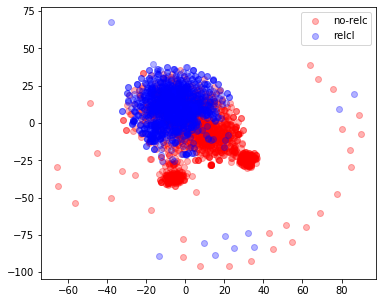

In [23]:
tsne(x_dev[:2500, :], y_dev[:2500], ind2label = {1: "relcl", 0: "no-relc"})

## Predict the presence of REC from the representation

In [24]:
avg = 0.
k = 10
for i in range(k):
    #model = LinearSVC(dual = False, max_iter = 10000) #SGDClassifier(max_iter = 200)
    model = SGDClassifier(max_iter = 10000, alpha = 0.01)
    model.fit(x_train, y_train)
    avg += model.score(x_dev, y_dev)

print(avg/k)
print(model.coef_[0,:10])

0.9565250000000001
[-0.06287484 -0.10700117  0.08332388  0.09129719  0.00806269  0.00110686
  0.02578384  0.04230453  0.08979812  0.03242392]


In [25]:
preds_dev = model.predict(x_dev)
mistakes = preds_dev != y_dev
mistakes_idx = np.arange(len(x_dev))[mistakes]
mistakes_idx[:100]
dev_data = data_with_bert_states[l:]
print(len(mistakes), len(data_with_bert_states))
mistakes_data = [d for i,d in enumerate(dev_data) if mistakes[i]]

mistakes_data[0]
for i in range(100):
    print(mistakes_data[i]["doc"])
    print("=======================================")

4000 20000
North to East curve where the lines had previously crossed , thereby giving direct access into Arkwright Colliery Yard without any reversals .
The Dor Daim movement was formed by individuals who were displeased by the influence of Kabbalah which had been introduced to Yemen in the 17th century .
Hence the postmodern condition is the replacement of metanarratives with a multiplicity of micro-narratives , or to call them the appellation Lyotard gave them , language games .
In 1985 , farmers successfully lobbied to have the elk removed , an effort that was eventually halted .
There is n't really much else to add on Transport and Schools and when you edit the page you get the warning `` This page is 33 kilobytes long .
AfD shows an anti-religious bias in the same way that a rejection of a BET source would show an anti-ethnic bias .
The idea for the episode was pitched by Omine , who based it on a lawsuit at the time , wherein smokers sued tobacco companies for selling harmful wa

## INLP

In [26]:
inlp_dataset = inlp_dataset_handler.ClassificationDatasetHandler(x_train, y_train, x_dev, y_dev, dropout_rate = 0, Y_train_main = None, Y_dev_main = None, by_class = False, equal_chance_for_main_task_labels = False)
#inlp_model_handler = inlp_linear_model.SKlearnClassifier(LinearSVC, {"dual": False, "max_iter": 5000})
inlp_model_handler = inlp_linear_model.SKlearnClassifier(SGDClassifier, {"max_iter": 10000, "alpha": 0.01, "n_iter_no_change": 10})

In [33]:
P, rowspace_projections, Ws = inlp.run_INLP(num_classifiers = 10, input_dim = 1024, is_autoregressive = True, min_accuracy = 0, dataset_handler = inlp_dataset, model = inlp_model_handler)

iteration: 9, accuracy: 0.699: 100%|██████████| 10/10 [00:40<00:00,  4.03s/it] 


In [34]:
P_rowspace = np.eye(P.shape[0]) - P

In [56]:
relc_vecs = np.array([x for x,y in zip(x_train, y_train) if y == 1])
non_relc_vecs = np.array([x for x,y in zip(x_train, y_train) if y == 0])
relc_data = [d for d in data_with_bert_states[:l] if d["label"] == 1]
relc_vecs.shape
relc_vecs_projected = P_rowspace.dot(relc_vecs.T).T

relc_vecs_projected_low_dim = []
for v in tqdm.notebook.tqdm(relc_vecs, total = len(relc_vecs)):
    
    v_rowspace = []
    for w in Ws:
        
        w_norm = w/np.linalg.norm(w)
        v_rowspace.append(w_norm.dot(v.T).item())
    
    v_rowspace = np.array(v_rowspace)
    relc_vecs_projected_low_dim.append(v_rowspace)
    
relc_vecs_projected_low_dim = np.array(relc_vecs_projected_low_dim)

is_reduced = np.array([True if d["is_reduced"] else False for d in relc_data])

vecs_reduced_relc = relc_vecs[is_reduced]
model.score(vecs_reduced_relc, np.ones(len(vecs_reduced_relc)))
is_reduced_docs = [d["doc"] for i,d in enumerate(relc_data) if is_reduced[i]]
for i in range(5):
    print(is_reduced_docs[i])
    print("======================================")
print("======================================================================")
    
is_obj_relc = np.array([True if d["doc"][d["relc_borders"][-1]].pos_ == "VERB" else False for d in relc_data])
is_obj_relc_docs = [d["doc"] for i,d in enumerate(relc_data) if is_obj_relc[i]]
vecs_obj_relc = relc_vecs[is_obj_relc]

for i in range(10):
    print(is_obj_relc_docs[i])
    print("======================================")


In his work , the stuff he was great at was coming up with the big , grand theory .
Since the 1970s there have been various initiatives to attempt to regenerate Coatbridge .
Harvey Postlethwaite , out of work since the demise of Tyrrell that same year , to design a chassis .
No refs , no other indication this is a term used in software circles .
New Brighton is one of the smallest settlements ever to have a Football League club , although it was in close proximity to the much larger Liverpool .
When He-Ping was six years old , Lin ( the merchant ) became ill with a mysterious disease which local doctors could not cure .
The fort , which was defended `` by rifle fire and mixed iron missiles from two old cannon '' , was captured with a loss of three killed and twelve wounded .
These latter are referred to as `` the Hidden Seed '' which John Amos Comenius had prayed would preserve the evangelical faith in the land of the fathers .
For years , Asa had typically favored trophy wives , much

In [36]:
relc_vecs_projected_low_dim.shape

(7949, 10)

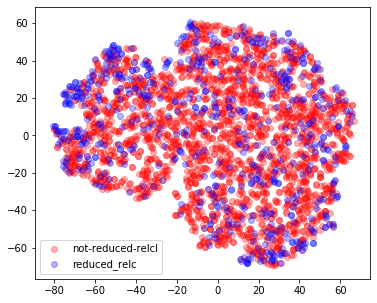

In [37]:
tsne(relc_vecs_projected_low_dim[:3000], is_reduced[:3000], ind2label = {1: "reduced_relc", 0: "not-reduced-relcl"})

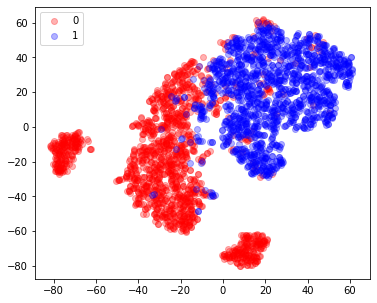

In [40]:
tsne(P_rowspace.dot(x_train.T).T[:3000], y_train[:3000])

In [43]:

def to_string(np_array):
        return "\t".join(["%0.4f" % x for x in np_array])


def save_vecs_and_labels(vecs, is_reduced_labels, is_object_labels, data):
    
    with open("vecs.tsv", "w") as f:
        
        for v in vecs:
            
            f.write(to_string(v) + "\n")
    
    with open("labels.tsv", "w") as f:
        
        f.write("sent" + "\t" + "relc" + "\t" + "is_reduced" + "\t" + "is_obj" + "\t" + "length" + "\n")
        
        for d, is_reduced, is_obj in zip(data, is_reduced_labels, is_object_labels):
        
            sent = [tok.text for tok in d["doc"]]
            borders = d["relc_borders"]
            length = abs(borders[1] - borders[0])
            
            for j,w in enumerate(sent):
            
                if j >= borders[0] and j <= borders[1]:
                
                    sent[j] = w.upper()
            
            relc = sent[borders[0]:borders[1]+1]
            f.write(" ".join(sent) + "\t"  + " ".join(relc).lower() + "\t" + str(is_reduced) + "\t" + str(is_obj) + "\t" + str(length) + "\n")
            
        

In [41]:
save_vecs_and_labels(relc_vecs_projected_low_dim, is_reduced, is_obj_relc, relc_data)

NameError: name 'save_vecs_and_labels' is not defined

In [ ]:
len(x_train)

In [59]:
dists_reduced = sklearn.metrics.pairwise_distances(vecs_reduced_relc)
dists_obj = sklearn.metrics.pairwise_distances(vecs_obj_relc)
dists_all = sklearn.metrics.pairwise_distances(relc_vecs)
dists_not_relc = sklearn.metrics.pairwise_distances(non_relc_vecs)

dists_reduced_after = sklearn.metrics.pairwise_distances(P_rowspace.dot(vecs_reduced_relc.T).T)
dists_obj_after = sklearn.metrics.pairwise_distances(P_rowspace.dot(vecs_obj_relc.T).T)
dists_all_after = sklearn.metrics.pairwise_distances(P_rowspace.dot(relc_vecs.T).T)
dists_not_relc_after = sklearn.metrics.pairwise_distances(P_rowspace.dot(non_relc_vecs.T).T)


In [61]:
print("reduced", np.mean(dists_reduced), np.mean(dists_reduced_after))
print("obj", np.mean(dists_obj), np.mean(dists_obj_after))
print("all", np.mean(dists_all), np.mean(dists_all_after))
print("not-relcl", np.mean(dists_not_relc), np.mean(dists_not_relc_after))

reduced 15.763644 2.6171529999537078
obj 17.118824 2.9563940073290302
all 14.286124 2.2460912003797753
not-relcl 14.806995 2.6272530923437873


In [46]:
relc_vecs.shape

(7949, 1024)